In [1]:
#importing the libraries
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [2]:
#convert the tensor to image
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [3]:
#upload the contect and the style image to the colab 
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
#pass the name of images
content_path = "image.jpg"
print("Content path : ",content_path)
style_path = "style2.jpg"
print("Style path : ", style_path)

In [17]:
#Visualize the input
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img


In [18]:
#to display an image
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

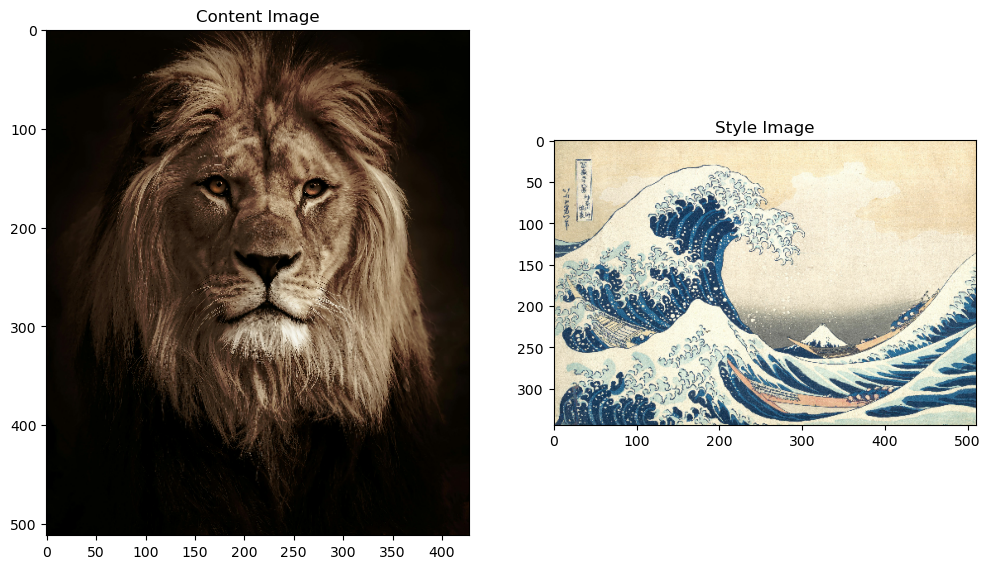

In [19]:
#display the images
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

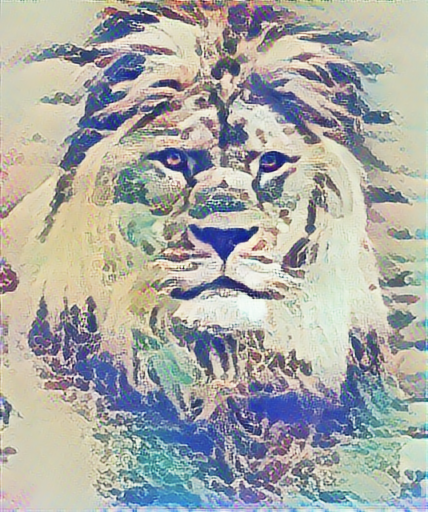

In [20]:
#Fast Style Transfer using TF-Hub
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [21]:
"""
  Using VGG19 Model
"""
#Defining content and style representations
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [22]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

35363/35363 [==============================] - 0s 2us/step


[('lion', 0.99998784),
 ('lynx', 7.1098775e-06),
 ('cheetah', 1.2098237e-06),
 ('chow', 9.915351e-07),
 ('Persian_cat', 7.3372024e-07)]

In [23]:
# Now load a VGG19 without the classification head, and list the layer names
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
print()
for layer in vgg.layers:
  print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [24]:
#Choose intermediate layers from the network to represent the style and content of the image:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [25]:
#Build the model
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [26]:
#create the model
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 344, 511, 64)
  min:  0.0
  max:  828.4937
  mean:  37.83442

block2_conv1
  shape:  (1, 172, 255, 128)
  min:  0.0
  max:  4061.137
  mean:  225.53728

block3_conv1
  shape:  (1, 86, 127, 256)
  min:  0.0
  max:  8878.158
  mean:  196.07057

block4_conv1
  shape:  (1, 43, 63, 512)
  min:  0.0
  max:  21949.95
  mean:  766.0289

block5_conv1
  shape:  (1, 21, 31, 512)
  min:  0.0
  max:  2846.788
  mean:  53.109



In [28]:
#Calculate the style
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [32]:
#Build a model that returns the style and content tensors.
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [33]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0
    max:  51838.406
    mean:  504.7291

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  69861.414
    mean:  14198.926

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  271006.88
    mean:  9772.803

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  3133243.2
    mean:  189295.78

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  95345.68
    mean:  1094.4335

Contents:
   block5_conv2
    shape:  (1, 32, 26, 512)
    min:  0.0
    max:  1390.6786
    mean:  12.173662


In [34]:
#Run gradient descent
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [35]:
#Optimize the image
image = tf.Variable(content_image)

In [36]:
#to keep the pixel value between 1 and 2
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [37]:
#create a adam optimizer
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [38]:
style_weight=1e-2
content_weight=1e4

In [39]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [40]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

In [41]:
#Regularizing the Model
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [42]:
total_variation_loss(image).numpy()

44175.883

In [43]:
total_variation_weight=30
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    #Added the regularized weights
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [44]:
image = tf.Variable(content_image)

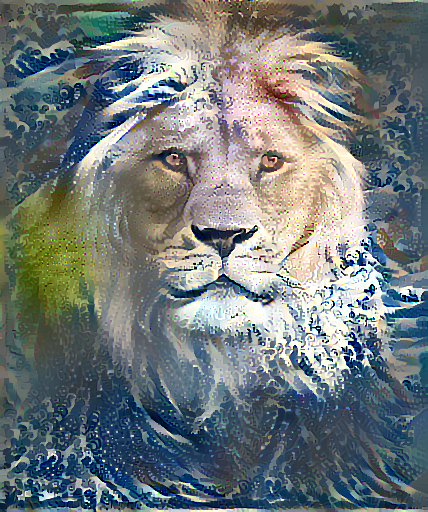

Train step: 1600
..........................................................................

KeyboardInterrupt: 

In [45]:
#Re run the Model
import time
start = time.time()

epochs = 50
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [46]:
#Download the image
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)
#tensor_to_image(stylized_image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)